In [1]:
from __future__ import division
import sys
import configparser
import json
import h5py as h5
import gzip
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.precision', 2)

sys.path.append('../Utils')
from utils import get_image_filename, invert_dict, get_a_by_b, query_by_id
from utils import plot_labelled_bb, plot_img_cropped, plot_img_ax
from data_utils import get_obj_bb, get_obj_key
sys.path.append('../WACs/WAC_Utils')
from wac_utils import filter_X_by_filelist, filter_refdf_by_filelist
from wac_utils import create_word2den, make_X_id_index, make_mask_matrix
from wac_utils import train_this_word, get_X_for_word

config = configparser.ConfigParser()
my_config = '../Config/default.cfg'
with open(my_config, 'r', encoding='utf-8') as f:
    config.read_file(f)

dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')
preproc_path = dsgv_home + '/Preproc/PreprocOut/'
feats_path = dsgv_home + '/ExtractFeats/ExtractOut/'
model_path = dsgv_home + '/WACs/ModelsOut/'
eval_path = dsgv_home + '/ApplyModels/EvalOut/'

In [2]:
ID_FEATS = 3

# Dataset split
with open(preproc_path + 'fr_splits.json', 'r') as f:
    splits = json.load(f)

# Features
with h5.File(feats_path + 'saiapr_bbdf_rsn50-max.hdf5') as f:
    img_fts = np.array(f["img_feats"])
with h5.File(feats_path + 'L1_wac_EN_3.hdf5') as f:
    l1_fts = np.array(f["img_feats"])
Xfr = img_fts
Xl2 = np.concatenate((img_fts, l1_fts[:, ID_FEATS:]), axis=1)
#X_tr = filter_X_by_filelist(X, splits['train'])

# Bounding boxes
s_bbdf = pd.read_json(preproc_path + 'saiapr_bbdf.json.gz',
                      typ='frame', orient='split', compression='gzip')

# FR ref exps
refexp_fr = pd.read_pickle(preproc_path + 'FR_small_dataset.pkl')
print('refexp_fr shape:', refexp_fr.shape)
# Test set
refdf = filter_refdf_by_filelist(refexp_fr, splits['test'])
print('Testing dataset:')
refdf.head()

refexp_fr shape: (10159, 7)
Testing dataset:


,i_corpus,image_id,region_id,r_corpus,rex_id,refexp_EN,refexp
0,0,20909,1,referit,49,kid,enfant
1,0,20909,3,referit,35225,dirt ground,terre battue
2,0,20909,2,referit,112956,the sky,Le ciel
3,0,2050,10,referit,56,man in red sweater,homme en pull rouge
4,0,2050,10,referit,2465,man in red,homme en rouge


In [3]:
# Models
with gzip.open(model_path + 'best_FR.pklz', 'r') as f:
    frwacs = pickle.load(f)

with gzip.open(model_path + 'best_L2.pklz', 'r') as f:
    l2wacs = pickle.load(f)

In [4]:
with gzip.open(eval_path + 'best_FR_results.pklz', 'r') as f:
    results_fr = pickle.load(f)
print(results_fr.shape)

with gzip.open(eval_path + 'best_L2_results.pklz', 'r') as f:
    results_l2 = pickle.load(f)
print(results_l2.shape)

(4950, 11)
(4950, 11)


In [5]:
results = results_l2.merge(results_fr, how='outer', suffixes=('_l2', '_fr'),
                           on=['i_corpus', 'image_id', 'region_id', 'r_corpus', 'rex_id', 'refexp_EN', 'refexp'])

succ_diff = results.loc[results['suc_l2'] != results['suc_fr']]
succ_diff.shape

(948, 15)

## What did L2 get right that FR didn't?

In [6]:
succ_l2 = succ_diff.loc[succ_diff['suc_l2'] == True]
succ_l2.head(n=20)

,i_corpus,image_id,region_id,r_corpus,rex_id,refexp_EN,refexp,cov_l2,suc_l2,rnk_l2,nob_l2,cov_fr,suc_fr,rnk_fr,nob_fr
1,0,20909,3,referit,35225,dirt ground,terre battue,0.50,True,1.0,3.0,0.50,False,2.0,3.0
3,0,2050,10,referit,56,man in red sweater,homme en pull rouge,0.75,True,1.0,12.0,0.75,False,2.0,12.0
4,0,2050,10,referit,2465,man in red,homme en rouge,1.00,True,1.0,12.0,1.00,False,2.0,12.0
16,0,2050,10,referit,109509,man in red,homme en rouge,1.00,True,1.0,12.0,1.00,False,2.0,12.0
21,0,19314,6,referit,29175,bottom left,en bas à gauche,1.00,True,1.0,8.0,1.00,False,5.0,8.0
22,0,19314,7,referit,48999,open most sky in the center,ouvrir la plupart du ciel au centre,0.71,True,1.0,8.0,0.71,False,2.0,8.0
30,0,31573,6,referit,113544,sports ball in hand,ballon de sport en main,0.60,True,1.0,6.0,0.60,False,5.0,6.0
46,0,12953,9,referit,56975,window upper right corner,coin supérieur droit de la fenêtre,1.00,True,1.0,21.0,1.00,False,5.0,21.0
62,0,14825,1,referit,107772,man,homme,1.00,True,1.0,4.0,1.00,False,2.0,4.0
70,0,24010,5,referit,72822,bottom right windows,fenêtres en bas à droite,0.80,True,1.0,8.0,0.80,False,3.0,8.0


### Example: 'Homme en pull rouge'

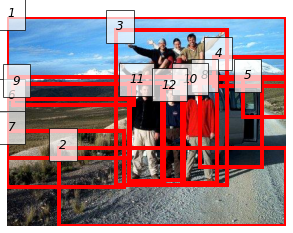

In [8]:
ic = 0  # saiapr corpus code
ii = 2050

redman = get_image_filename(config, ic, ii)

bbs = [(bb, region_id) 
       for bb, region_id in query_by_id(s_bbdf, (ic, ii), ['bb', 'region_id']).values]
plot_labelled_bb(redman, bbs, figsize=(5,5))

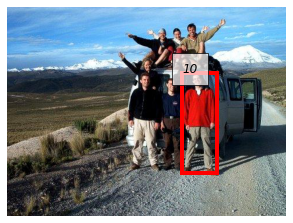

In [9]:
plot_labelled_bb(redman, [bbs[9]],figsize=(5,5))

In [10]:
fts_fr = filter_X_by_filelist(Xfr, [2050,])[:, ID_FEATS:]
print('FR feature vec:', fts_fr.shape)
fts_l2 = filter_X_by_filelist(Xl2, [2050,])[:, ID_FEATS:]
print('L2 feature vec:', fts_l2.shape)

FR feature vec: (12, 2055)
L2 feature vec: (12, 2461)


In [11]:
def apply_words(X_tst, wac, refexp_toks_wac):
    response_vectors = []
    for word in refexp_toks_wac:
        response_vector = np.array(wac[word]['clsf'].predict_proba(X=X_tst)[:,1])
        response_vectors.append(response_vector)
    response_matrix = np.array(response_vectors).T   # n_objs x n_words
    return response_matrix

Probabilities per region:

In [76]:
compfunc=lambda x:np.sum(x, axis=1)
refexp = ['homme', 'en', 'rouge']

results = [apply_words(fts_fr, frwacs, refexp),]
results.append(apply_words(fts_l2, l2wacs, refexp))

composed = []
for r in results:
    cr = compfunc(r)
    print(cr)
    composed.append(cr)
    
c = ['reg' + str(i) for i in range(1,13)]
df = pd.DataFrame.from_records(composed, index=['FR','L2'], columns=c)
df

[1.73984062e-03 1.00000253e+00 3.38545148e-03 1.00002922e+00
 8.07788861e-05 4.50728758e-01 1.60122248e-02 1.37925706e+00
 9.82567847e-01 1.36502189e+00 9.51677506e-01 1.19686806e+00]
[8.83343779e-02 9.97810671e-01 9.79993324e-01 8.42486299e-01
 1.09844642e-05 7.61825239e-05 1.89377849e-01 1.57594997e+00
 8.39647251e-03 2.03911939e+00 1.86251808e+00 1.99873532e+00]


,reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9,reg10,reg11,reg12
FR,1.74e-03,1.0,3.39e-03,1.00,8.08e-05,4.51e-01,0.02,1.38,9.83e-01,1.37,0.95,1.2
L2,8.83e-02,1.0,9.80e-01,0.84,1.10e-05,7.62e-05,0.19,1.58,8.40e-03,2.04,1.86,2.0


What words give highest probabilities for the regions?

In [59]:
# Get probabilities for each word on region
fr_reg_probs = np.zeros((len(frwacs), len(fts_fr)))

for i,w in enumerate(frwacs.keys()):
    prob = np.array(frwacs[w]['clsf'].predict_proba(X=fts_fr)[:,1])
    fr_reg_probs[i] = prob

fr_probs = pd.DataFrame(fr_reg_probs, index=frwacs.keys(), columns=c)
fr_probs.head()

,reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9,reg10,reg11,reg12
coin,2.30e-06,4.16e-01,3.29e-05,4.44e-06,3.43e-06,5.37e-05,2.69e-02,6.28e-06,8.20e-01,1.10e-03,2.53e-06,6.92e-05
inférieur,4.12e-07,7.44e-02,1.02e-05,1.11e-05,3.72e-06,6.67e-05,3.87e-04,1.65e-06,1.22e-02,2.19e-04,3.27e-06,2.91e-06
gauche,8.14e-02,1.46e-05,2.08e-03,1.85e-04,4.37e-06,3.18e-01,9.28e-01,1.04e-07,9.99e-01,1.81e-03,1.16e-04,2.34e-03
en,1.60e-03,1.00e+00,4.31e-06,1.00e+00,1.07e-09,4.51e-01,1.60e-02,6.27e-01,9.82e-01,9.93e-01,2.79e-02,3.16e-01
bas,7.32e-02,9.61e-01,5.67e-08,7.88e-06,1.72e-04,3.25e-03,8.58e-04,2.68e-04,3.12e-04,8.31e-03,3.95e-05,7.44e-02


In [60]:
fr_probs.idxmax()

reg1       ciel
reg2         en
reg3         de
reg4         en
reg5         au
reg6         au
reg7     gauche
reg8          à
reg9     gauche
reg10         à
reg11        de
reg12        de
dtype: object

Prepositions score highest on nearly all regions...

In [61]:
fr_probs.reg10.sort_values(ascending=False).head(n=10)

à           1.00
en          0.99
de          0.80
droite      0.74
personne    0.70
femme       0.66
veste       0.58
mec         0.54
et          0.36
chemise     0.20
Name: reg10, dtype: float64

...and take up the top three slots here. Key words nowhere to be seen.

## What did FR get right that L2 didn't?

In [7]:
succ_fr = succ_diff.loc[succ_diff['suc_fr'] == True]
succ_fr.head(n=20)

,i_corpus,image_id,region_id,r_corpus,rex_id,refexp_EN,refexp,cov_l2,suc_l2,rnk_l2,nob_l2,cov_fr,suc_fr,rnk_fr,nob_fr
33,0,12953,1,referit,5670,whole table,table entière,0.50,False,2.0,21.0,0.50,True,1.0,21.0
34,0,12953,1,referit,8303,table,table,1.00,False,2.0,21.0,1.00,True,1.0,21.0
38,0,12953,1,referit,21655,table,table,1.00,False,2.0,21.0,1.00,True,1.0,21.0
42,0,12953,1,referit,45406,table,table,1.00,False,2.0,21.0,1.00,True,1.0,21.0
43,0,12953,1,referit,45458,table,table,1.00,False,2.0,21.0,1.00,True,1.0,21.0
48,0,12953,1,referit,64935,table,table,1.00,False,2.0,21.0,1.00,True,1.0,21.0
69,0,24010,6,referit,67037,window up right,fenêtre en haut à droite,1.00,False,2.0,8.0,1.00,True,1.0,8.0
86,0,9023,23,referit,22954,ad of woman on wall far left upper,annonce d'une femme sur le mur en haut à gauche,0.80,False,2.0,23.0,0.80,True,1.0,23.0
113,0,9315,7,referit,24946,bushes to the right,buissons à droite,0.67,False,2.0,13.0,0.67,True,1.0,13.0
132,0,22811,1,referit,78048,the car red part only,la partie rouge de la voiture seulement,0.86,False,2.0,3.0,0.86,True,1.0,3.0


### Example: 'Table'

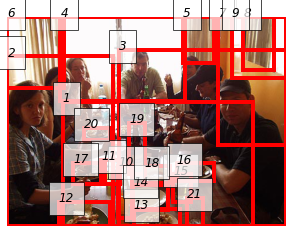

In [12]:
ii = 12953
table = get_image_filename(config, ic, ii)

bbs = [(bb, region_id) 
       for bb, region_id in query_by_id(s_bbdf, (ic, ii), ['bb', 'region_id']).values]
plot_labelled_bb(table, bbs, figsize=(5,5))

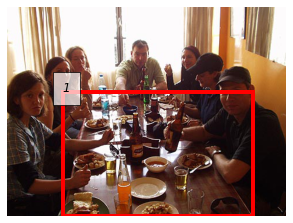

In [14]:
plot_labelled_bb(table, [bbs[0]], figsize=(5,5))

In [15]:
fts_fr = filter_X_by_filelist(Xfr, [ii,])[:, ID_FEATS:]
print('FR feature vec:', fts_fr.shape)
fts_l2 = filter_X_by_filelist(Xl2, [ii,])[:, ID_FEATS:]
print('L2 feature vec:', fts_l2.shape)

FR feature vec: (21, 2055)
L2 feature vec: (21, 2461)


In [17]:
compfunc=lambda x:np.sum(x, axis=1)
refexp = ['table']

results = [apply_words(fts_fr, frwacs, refexp),]
results.append(apply_words(fts_l2, l2wacs, refexp))

composed = []
for r in results:
    cr = compfunc(r)
    print(cr)
    composed.append(cr)
    
c = ['reg' + str(i) for i in range(1,22)]
df = pd.DataFrame.from_records(composed, index=['FR','L2'], columns=c)
df

[9.61083010e-01 3.77774722e-01 8.49121855e-01 4.54673990e-07
 5.47129313e-04 5.37741285e-06 1.11928605e-06 2.30626115e-03
 4.83270191e-04 4.10596931e-03 9.09810636e-01 1.12228991e-01
 7.19131510e-02 6.83883282e-03 1.52221939e-02 5.78243253e-02
 8.50994524e-01 1.22523149e-03 5.38119807e-02 7.77042249e-03
 6.82253468e-03]
[7.92153714e-01 4.04701126e-01 9.22954744e-01 3.81666600e-06
 4.45784508e-04 1.23368143e-05 1.70586189e-05 1.57063475e-04
 1.29001499e-02 5.54887693e-02 7.72707888e-01 6.81101667e-02
 1.68797621e-01 7.90155341e-03 7.41458426e-02 5.92727546e-02
 2.49325862e-01 1.41459969e-03 3.53734329e-01 3.96962163e-02
 1.78352474e-05]


,reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9,reg10,...,reg12,reg13,reg14,reg15,reg16,reg17,reg18,reg19,reg20,reg21
FR,0.96,0.38,0.85,4.55e-07,5.47e-04,5.38e-06,1.12e-06,2.31e-03,4.83e-04,4.11e-03,...,0.11,0.07,6.84e-03,0.02,0.06,0.85,1.23e-03,0.05,7.77e-03,6.82e-03
L2,0.79,0.40,0.92,3.82e-06,4.46e-04,1.23e-05,1.71e-05,1.57e-04,1.29e-02,5.55e-02,...,0.07,0.17,7.90e-03,0.07,0.06,0.25,1.41e-03,0.35,3.97e-02,1.78e-05


In [20]:
# Get probabilities for each word on region
l2_reg_probs = np.zeros((len(l2wacs), len(fts_l2)))

for i,w in enumerate(l2wacs.keys()):
    prob = np.array(l2wacs[w]['clsf'].predict_proba(X=fts_l2)[:,1])
    l2_reg_probs[i] = prob

l2_probs = pd.DataFrame(l2_reg_probs, index=l2wacs.keys(), columns=c)
l2_probs.idxmax()

reg1         les
reg2      gauche
reg3       table
reg4      gauche
reg5           à
reg6      gauche
reg7          en
reg8          en
reg9          le
reg10         en
reg11          à
reg12     gauche
reg13     gauche
reg14         le
reg15     gauche
reg16         en
reg17     gauche
reg18          à
reg19          à
reg20          à
reg21    partant
dtype: object

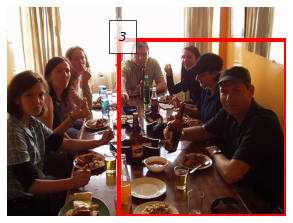

In [25]:
plot_labelled_bb(table, [bbs[2],], figsize=(5,5))

So it got 'table' for region 3, which does indeed include the table, but not for region 1.

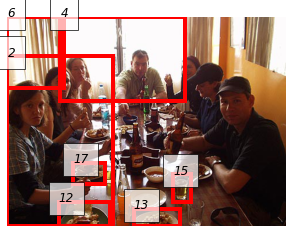

In [22]:
# Plot regions with top prediction 'gauche'
plot_labelled_bb(table, [bbs[1], bbs[3], bbs[5], bbs[11], bbs[12], bbs[14], bbs[16]], figsize=(5,5))

Good predictions here of 'gauche' (left)

In [26]:
l2_probs.reg10.sort_values(ascending=False).head(n=10)

en           1.00
la           1.00
à            0.97
le           0.87
bouteille    0.85
au           0.79
du           0.42
d'eau        0.35
plus         0.30
droite       0.27
Name: reg10, dtype: float64

Prepositions and articles come out top, but good to see bottle, water, right

## Classifier scores
FR:

In [94]:
word2den = create_word2den(refdf)
X_idx = make_X_id_index(Xfr)
mask_matrix = make_mask_matrix(Xfr, X_idx, word2den, word2den.keys())

scores = []
for i,w in enumerate(frwacs.keys()):
    if w in word2den:
        X, y = get_X_for_word(Xfr, word2den, mask_matrix, w)
        score = frwacs[w]['clsf'].score(X, y)
        scores.append(score)
        #print(w,'\t\t', score)
    else:
        scores.append(0.0)
scores_df = pd.Series(scores, index=frwacs.keys())
scores_df.sort_values(ascending=False)

bureau    1.00
tenant    1.00
l'une     1.00
pont      1.00
tache     1.00
          ... 
droite    0.81
gauche    0.77
de        0.75
en        0.74
à         0.63
Length: 187, dtype: float64

L2:

In [96]:
X_idx = make_X_id_index(Xl2)
mask_matrix = make_mask_matrix(Xl2, X_idx, word2den, word2den.keys())

scores = []
for i,w in enumerate(l2wacs.keys()):
    if w in word2den:
        X, y = get_X_for_word(Xl2, word2den, mask_matrix, w)
        score = l2wacs[w]['clsf'].score(X, y)
        scores.append(score)
        #print(w,'\t\t', score)
    else:
        scores.append(0.0)
scores_df2 = pd.Series(scores, index=l2wacs.keys())
scores_df2.sort_values(ascending=False)

tache     1.00
tenant    1.00
l'une     1.00
étage     1.00
clair     1.00
          ... 
droite    0.86
de        0.78
gauche    0.67
en        0.65
à         0.60
Length: 187, dtype: float64